In [1]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
import torch

In [2]:
from sklearn.cluster import KMeans
import numpy as np

In [3]:
from collections import Counter
import itertools

In [4]:
#pip install transformers torch

In [9]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_noties_short.csv')

# Load the pre-trained DistilBERT model and tokenizer
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.eval()

# Tokenize and generate DistilBERT embeddings for each notification
def get_distilbert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()

# Apply DistilBERT embeddings to the cleaned dataset
df['embeddings'] = df['clean_text'].apply(get_distilbert_embeddings)

In [11]:
# Display the first few rows of the dataset to ensure embeddings are added
print(df[['clean_text', 'embeddings']].head())

                              clean_text  \
0             abutment low lift and pack   
1              abutment low top and line   
2   abutment sink hole right side to fil   
3  access roadhardstand julia creek area   
4                     access roads flynn   

                                          embeddings  
0  [0.050723374, -0.09403566, -0.096362546, 0.072...  
1  [-0.036000527, -0.123835735, -0.18339089, -0.0...  
2  [-0.18107376, -0.21624507, -0.23229569, -0.081...  
3  [0.035576377, 0.3054983, -0.10641304, 0.121964...  
4  [0.095406346, 0.24585977, -0.06019389, 0.13787...  


In [11]:
# Convert embeddings to a matrix for clustering
embeddings_matrix = np.vstack(df['embeddings'].values)

# Perform K-Means clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_matrix)

# Display the clustered data
print(df[['clean_text', 'cluster']].head())

                              clean_text  cluster
0             abutment low lift and pack        3
1              abutment low top and line        3
2   abutment sink hole right side to fil        3
3  access roadhardstand julia creek area        2
4                     access roads flynn        1


In [11]:
# Group notifications by cluster and view samples from each cluster
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    print(df[df['cluster'] == cluster_num][['clean_text']].head(10))


Cluster 0:
                       clean_text
16                adjust top line
17             adjust top line km
18             adjust top line km
20                  agms top line
24                  agms top left
25                  agms top line
26                 agms top right
29     agms top versine lr at the
31  agms top versine right at the
32              agms twist at the

Cluster 1:
                      clean_text
4             access roads flynn
5      access roads flynn mt isa
6   access roads flynn phosphate
7       access roads to marathon
9    access roads marathon curry
12       adjust cheese weight km
13                  adjust gauge
19                    adjust top
21     agms inspection flynn isa
22               agms top defect

Cluster 2:
                                  clean_text
3      access roadhardstand julia creek area
8         access roads julia creek cloncurry
10          access roads stuart to hughenden
30              agms top versine left at the
37

In [12]:
# Check the size of each cluster
cluster_sizes = df['cluster'].value_counts()
print(cluster_sizes)

cluster
1    1966
0    1567
2    1317
3    1302
4    1187
Name: count, dtype: int64


In [14]:
# Tokenize the text for word frequency analysis
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

# Word frequency analysis for each cluster
for cluster_num in sorted(df['cluster'].unique()):
    words_in_cluster = list(itertools.chain(*df[df['cluster'] == cluster_num]['tokens'].tolist()))
    word_freq = Counter(words_in_cluster)
    
    print(f"\nCluster {cluster_num} - Top words:")
    print(word_freq.most_common(10))


Cluster 0 - Top words:
[('top', 598), ('km', 592), ('line', 414), ('mmy', 410), ('and', 335), ('to', 219), ('twist', 171), ('right', 122), ('left', 115), ('down', 113)]

Cluster 1 - Top words:
[('km', 508), ('rail', 311), ('to', 299), ('replace', 240), ('track', 238), ('vegetation', 148), ('clips', 131), ('defect', 121), ('missing', 117), ('remove', 84)]

Cluster 2 - Top words:
[('km', 245), ('road', 218), ('track', 218), ('to', 202), ('rail', 185), ('line', 162), ('top', 149), ('rough', 144), ('and', 128), ('up', 122)]

Cluster 3 - Top words:
[('rail', 420), ('ballast', 398), ('to', 283), ('sleepers', 209), ('km', 152), ('replace', 146), ('track', 120), ('deficient', 96), ('defect', 93), ('weld', 91)]

Cluster 4 - Top words:
[('rail', 548), ('gnr', 420), ('rti', 416), ('geometry', 400), ('ballast', 378), ('gnrrti', 332), ('rr', 248), ('lr', 239), ('dw', 222), ('td', 217)]


In [13]:
import nltk
from nltk.corpus import stopwords

In [15]:
# Add custom stopwords
custom_stop_words = ['km', 'mmy', 'rd', 'rr', 'gnrrti', 'dw', 'td', 'cl', 'lr', 'gnr', 
                     'rti', 'ro', 'vsh', 'insp', 'flynn', 'isa', 'mm', 'hsh', 'bc', 'rh', 'pdr', 'lh', 'dn', 'tm', 'rrv', 'mt']

# Combine with NLTK's stopwords
stop_words = set(stopwords.words('english')).union(custom_stop_words)

In [17]:
# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply the stopword removal
df['tokens'] = df['clean_text'].apply(lambda x: x.split())  # Tokenize text
df['tokens'] = df['tokens'].apply(remove_stopwords)  # Remove stopwords

In [19]:
# Word frequency analysis for each cluster
for cluster_num in sorted(df['cluster'].unique()):
    words_in_cluster = list(itertools.chain(*df[df['cluster'] == cluster_num]['tokens'].tolist()))
    word_freq = Counter(words_in_cluster)
    
    print(f"\nCluster {cluster_num} - Top words:")
    print(word_freq.most_common(20))


Cluster 0 - Top words:
[('twist', 171), ('right', 122), ('left', 115), ('clips', 93), ('missing', 89), ('versine', 78), ('replace', 70), ('road', 56), ('weld', 48), ('versign', 46), ('vee', 44), ('cant', 35), ('bolts', 35), ('track', 34), ('defect', 34), ('x', 32), ('ballast', 31), ('points', 29), ('holding', 29), ('dwn', 28)]

Cluster 1 - Top words:
[('rail', 311), ('replace', 240), ('track', 238), ('vegetation', 148), ('clips', 131), ('defect', 121), ('missing', 117), ('remove', 84), ('control', 77), ('ballast', 73), ('road', 68), ('inspection', 66), ('repair', 65), ('sleepers', 56), ('broken', 55), ('magnet', 52), ('rough', 51), ('relay', 46), ('board', 40), ('yard', 40)]

Cluster 2 - Top words:
[('road', 218), ('track', 218), ('rail', 185), ('rough', 144), ('resurface', 103), ('yard', 72), ('weld', 66), ('resurf', 64), ('sleepers', 61), ('cloncurry', 59), ('broken', 59), ('vegetation', 48), ('missing', 47), ('patrol', 47), ('inspection', 44), ('stuart', 43), ('replace', 43), ('hug

### This output shows the most common words for each cluster. if certain clusters are focused on specific topics 

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

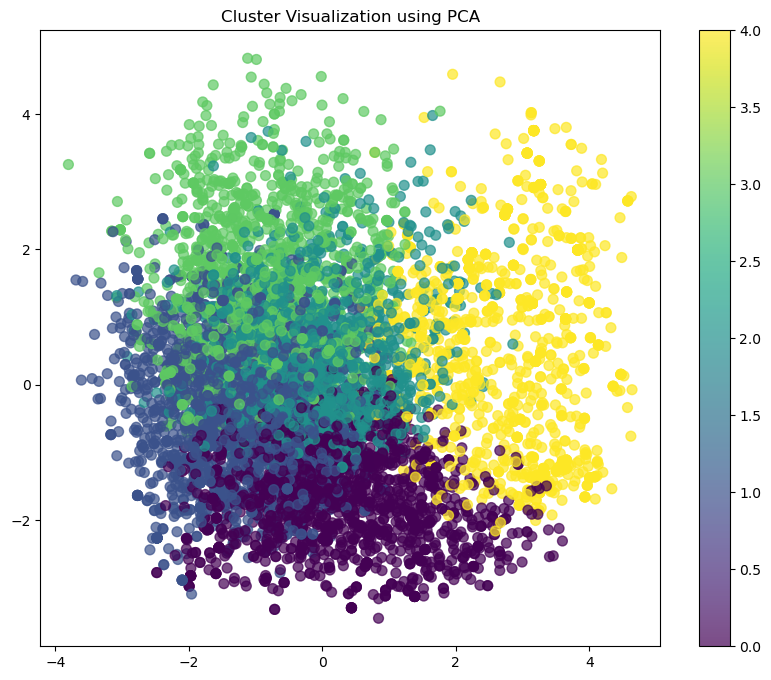

In [43]:
# Reduce the dimensionality of embeddings to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title("Cluster Visualization using PCA")
plt.show()

In [44]:
from sklearn.manifold import TSNE

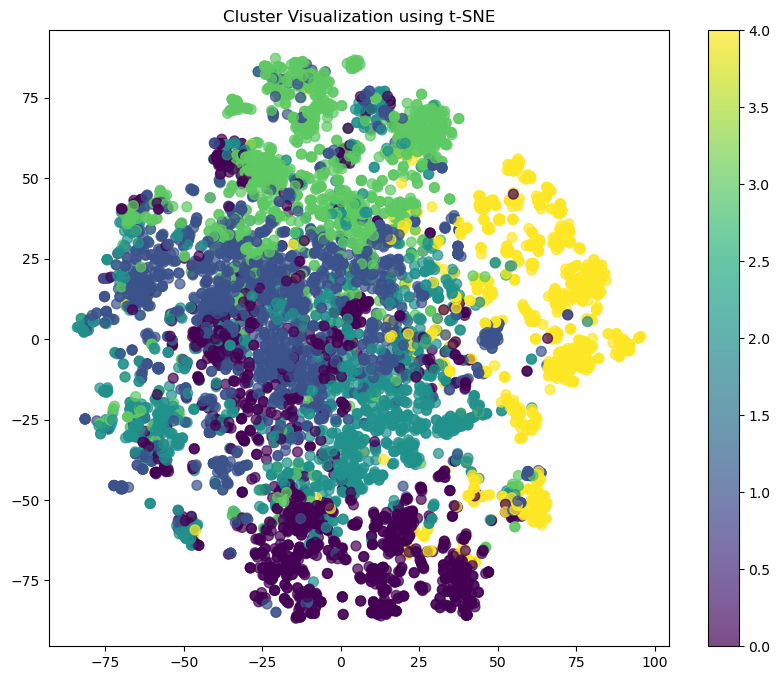

In [45]:
# Reduce the dimensionality of embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(embeddings_matrix)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title("Cluster Visualization using t-SNE")
plt.show()

- Inspect cluster contents to see what types of notifications are grouped together.
- Check cluster sizes to ensure balanced clusters.
- Perform word frequency analysis to identify common terms within each cluster.
- Visualize clusters to better understand their distribution in reduced dimensions (PCA or t-SNE).
- Identify themes from the clusters based on the analysis and common words.